In [27]:
import networkx as nx
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
import sys
from dgl.nn import GraphConv#instead of GCNConv in PyG
import dgl
sys.path.append('..')
from model.models_dgl import GraphConvWL
from ba4label_dgl_total import *

from torch import nn
def generate_single_sample(label, perturb_type, nodes_num = 25, m = 1, perturb_dic = {}, 
seed = None):
    '''
    return a networkx instance
    '''
    basis_type = "ba"
    which_type = label
    if which_type == 0:
        if perturb_type == 0:
            G, role_id, plug_id = build_graph(nodes_num, basis_type, [], start = 0, m = m, seed = seed)
        else:
            G, role_id, plug_id = build_graph(nodes_num - perturb_type, basis_type, [[perturb_dic[perturb_type]]], start = 0, m = m, seed = seed)
    else:
        list_shapes = [["house"]] * (which_type - 1) + [["five_cycle"]] * (3 - which_type)
        if perturb_type != 0:
            list_shapes = list_shapes + [[perturb_dic[perturb_type]]]
        G, role_id, plug_id = build_graph(nodes_num-10-perturb_type, basis_type, list_shapes, start = 0, m = m, seed = seed)
    return G

class FixedNet(nn.Module):
    def __init__(self, num_node_features, num_classes, num_layers, concat_features, conv_type):
        super(FixedNet, self).__init__()
        dim = 1
        self.convs = torch.nn.ModuleList()
        if conv_type == 'GraphConvWL':#'GCNConv':
            conv_class = GraphConvWL
            #kwargs = {'add_self_loops': False}
        elif conv_type == 'GraphConv':
            conv_class = GraphConv
            kwargs = {}
        else:
            raise RuntimeError(f"conv_type {conv_type} not supported")

        self.convs.append(conv_class(num_node_features, dim, bias = False))#, **kwargs))
        for i in range(num_layers - 1):
            self.convs.append(conv_class(dim, dim, bias = False))#, **kwargs))
        self.concat_features = concat_features


    def forward(self, g, x):
        '''
        g: DGL Graph
        x: node feature
        '''
        xs = [x]
        for conv in self.convs:
            x = conv(g, x)
            x = F.relu(x)
            xs.append(x)
        if self.concat_features:
            x = torch.cat(xs, dim=1)
        g.ndata['h'] = x
        hg = dgl.mean_nodes(g, 'h')
        return hg, xs

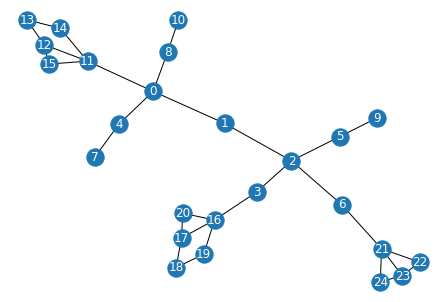

In [40]:
nodes_num = 25
G = generate_single_sample(3, 4, nodes_num, perturb_dic = {4:'square_diagonal'}, seed = 0)
pos = nx.spring_layout(G, seed = 0)
nx.draw(G, pos, with_labels = True, font_color = 'white')

In [41]:
model1 = FixedNet(1, 4, 1, True, 'GraphConvWL')
model2 = FixedNet(1, 4, 2, True, 'GraphConvWL')
model3 = FixedNet(1, 4, 3, True, 'GraphConvWL')
model4 = FixedNet(1, 4, 4, True, 'GraphConvWL')
for i in range(1, 5):
    for p in eval('model'+str(i)).parameters():
        torch.nn.init.constant_(p, 1)

In [42]:
output1, h1 = model1(dgl.from_networkx(G), torch.ones((nodes_num,1)))
print(h1[1])

tensor([[5.],
        [3.],
        [5.],
        [3.],
        [3.],
        [3.],
        [3.],
        [2.],
        [3.],
        [2.],
        [2.],
        [5.],
        [4.],
        [3.],
        [3.],
        [3.],
        [5.],
        [4.],
        [3.],
        [3.],
        [3.],
        [5.],
        [3.],
        [4.],
        [3.]], grad_fn=<ReluBackward0>)
